In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import logging
import sys
from brats_dataset import BratsDataset
import brats_dataset as bd
import visualisation
import importlib
import inference
import data_processing as dproc
from loss import DiceLoss
import elastic_transform
import pipeline

from sewar.full_ref import rmse

# configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

device = "cuda" if torch.cuda.is_available() else "cpu"
sample = 1552  # 547 # 1552

plt.ion()

LOCAL_BRATS = "/Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021"
VAST_BRATS = "/root/data/BraTS_full"
brats = BratsDataset(LOCAL_BRATS)

In [97]:
mri, segmentation = brats.load_sample(sample)
logging.info(f"mri shape: {mri.shape}")


2023-09-19 07:05:14,332 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_flair.nii.gz (took 0.1s)
2023-09-19 07:05:14,431 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_t1.nii.gz (took 0.1s)
2023-09-19 07:05:14,534 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_t1ce.nii.gz (took 0.1s)
2023-09-19 07:05:14,636 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_t2.nii.gz (took 0.1s)
2023-09-19 07:05:14,687 [INFO] MRI image shape: (4, 240, 240, 144)
2023-09-19 07:05:14,724 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_seg.nii.gz (took 0.0s)
2023-09-19 0

torch.Size([240, 240, 155])


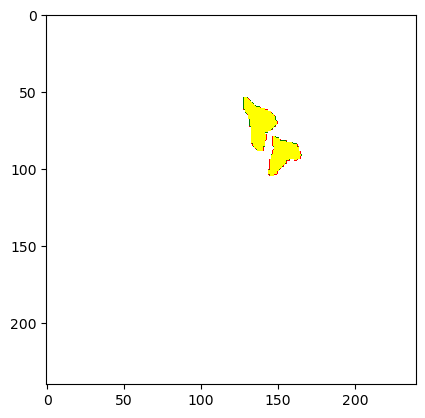

In [82]:
target = bd.unclip_4d(segmentation)
target = target[0]
target = torch.as_tensor(target, dtype=torch.int)
print(target.shape)
plt.imshow(target[:, :, 110].T, cmap=visualisation.segmentation_cmap)
plt.grid(False)

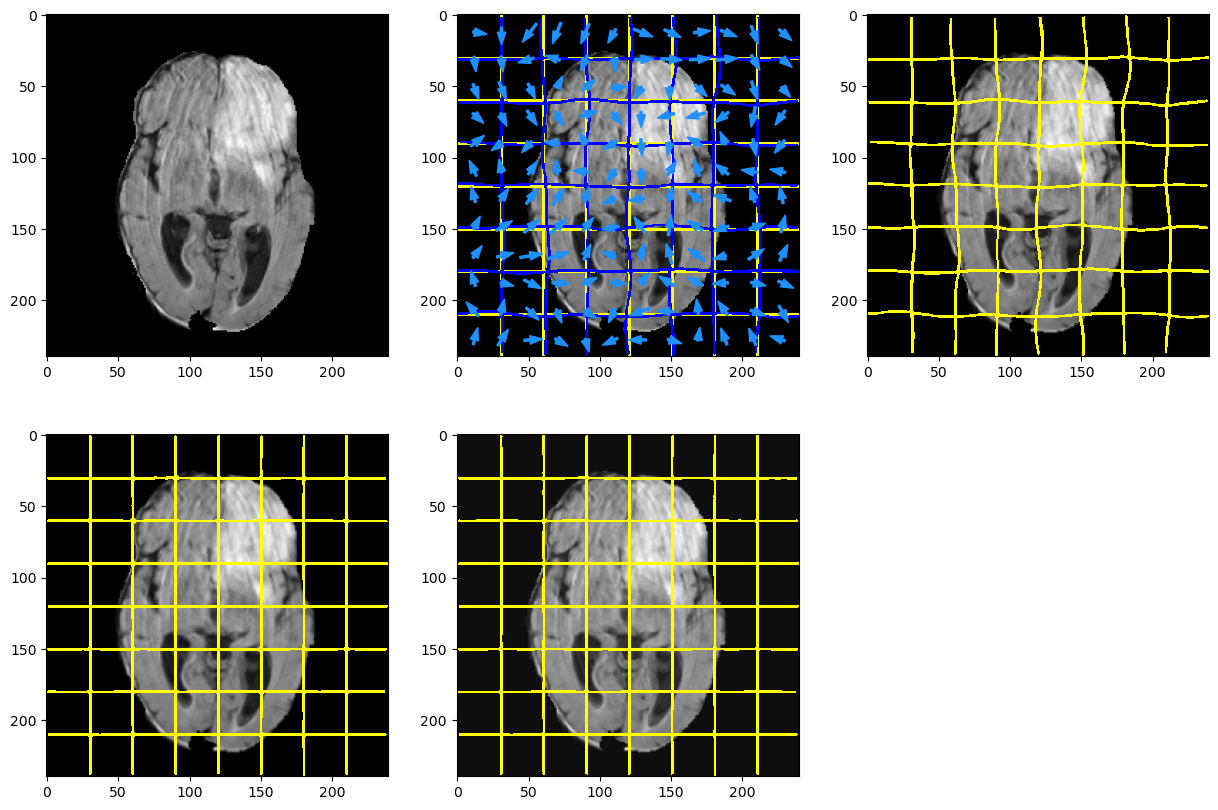

In [56]:
# Visualisation 2D


import importlib
import elastic_transform

importlib.reload(elastic_transform)

grid = visualisation.create_grid()

image = mri[0, :, :, 61]
alpha = 100
sigma = 13

transformed, dx, dy = elastic_transform.elastic_transform(image, alpha=alpha, sigma=sigma, order=1)
grid_transformed, _, _ = elastic_transform.elastic_transform(grid, alpha=alpha, sigma=sigma, dx=dx,
                                                             dy=dy, order=1)

restored, _, _ = elastic_transform.elastic_transform(transformed, alpha=alpha, sigma=sigma, dx=-dx,
                                                     dy=-dy,
                                                     order=1)
grid_restored, _, _ = elastic_transform.elastic_transform(grid_transformed, alpha=alpha,
                                                          sigma=sigma, dx=-dx,
                                                          dy=-dy, order=1)

restored2, _, _ = elastic_transform.elastic_transform(transformed, alpha=alpha, sigma=sigma, dx=-dx,
                                                      dy=-dy,
                                                      order=2)
grid_restored2, _, _ = elastic_transform.elastic_transform(grid_transformed, alpha=alpha,
                                                           sigma=sigma, dx=-dx,
                                                           dy=-dy, order=2)

restored3, _, _ = elastic_transform.elastic_transform(transformed, alpha=alpha, sigma=sigma, dx=-dx,
                                                      dy=-dy,
                                                      order=3)
grid_restored3, _, _ = elastic_transform.elastic_transform(grid_transformed, alpha=alpha,
                                                           sigma=sigma, dx=-dx,
                                                           dy=-dy, order=3)

restored4, _, _ = elastic_transform.elastic_transform(transformed, alpha=alpha, sigma=sigma, dx=-dx,
                                                      dy=-dy,
                                                      order=4)
grid_restored4, _, _ = elastic_transform.elastic_transform(grid_transformed, alpha=alpha,
                                                           sigma=sigma, dx=-dx,
                                                           dy=-dy, order=4)

restored5, _, _ = elastic_transform.elastic_transform(transformed, alpha=alpha, sigma=sigma, dx=-dx,
                                                      dy=-dy,
                                                      order=5)
grid_restored5, _, _ = elastic_transform.elastic_transform(grid_transformed, alpha=alpha,
                                                           sigma=sigma, dx=-dx,
                                                           dy=-dy, order=5)

columns = 3
rows = 2
fig = plt.figure(figsize=(15, 10))

# source
fig.add_subplot(rows, columns, 1)
plt.imshow(image.T, cmap='gray')

# with grid and field
fig.add_subplot(rows, columns, 2)
plt.imshow(image.T, cmap='gray')
plt.imshow(grid.T, cmap=visualisation.grid_cmap)
visualisation.draw_displacement_forces(image.shape, dx, dy, transpose=True)
plt.imshow(grid_transformed.T, cmap=colors.ListedColormap(
    ['none', 'blue']))

# transformed with grid
fig.add_subplot(rows, columns, 3)
plt.imshow(transformed.T, cmap='gray')
plt.imshow(grid_transformed.T, cmap=visualisation.grid_cmap)

# restored with grid
fig.add_subplot(rows, columns, 4)
plt.imshow(restored.T, cmap='gray')
plt.imshow(grid_restored.T, cmap=visualisation.grid_cmap)

# restored with grid
fig.add_subplot(rows, columns, 5)
plt.imshow(restored5.T, cmap='gray')
plt.imshow(grid_restored5.T, cmap=visualisation.grid_cmap)

plt.show()


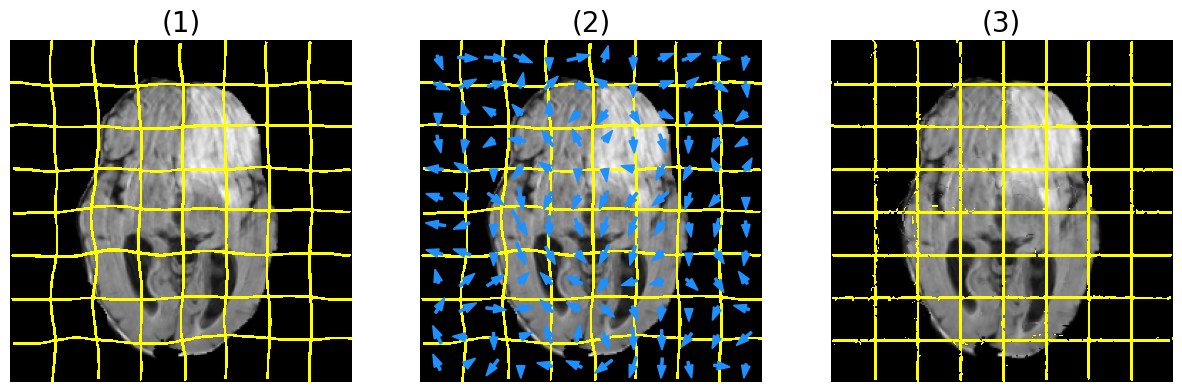

In [57]:
# NEW RESTORE (apply -dx not from the same point, but from (x+dx), back to x)

from scipy.ndimage import gaussian_filter
import skimage
import elastic_transform

importlib.reload(elastic_transform)

transformed_2, dx, dy = elastic_transform.elastic_transform(
    image, alpha=alpha, sigma=sigma, order=1)
grid_transformed_2, _, _ = elastic_transform.elastic_transform(grid, alpha=alpha, sigma=sigma,
                                                               dx=dx,
                                                               dy=dy, order=1)

# ---------------------------

shape = image.shape
factor = 6
new_shape = (np.asarray(shape) * factor).tolist()

dx1 = skimage.transform.rescale(dx, factor) * factor
dy1 = skimage.transform.rescale(dy, factor) * factor

dx1_rounded = dx1  #.round().astype(int)
dy1_rounded = dy1  #.round().astype(int)

xs = np.arange(new_shape[1]).astype(int)
ys = np.arange(new_shape[0]).astype(int)
x, y = np.meshgrid(xs, ys, indexing='xy')

x_shifted = x + dx1_rounded
y_shifted = y + dy1_rounded

x_shifted_r = skimage.transform.downscale_local_mean(x_shifted, factors=(factor, factor)) / factor
y_shifted_r = skimage.transform.downscale_local_mean(y_shifted, factors=(factor, factor)) / factor

x_shifted_rr = x_shifted_r.round().astype(int)
y_shifted_rr = y_shifted_r.round().astype(int)

x_shifted_rr = np.clip(x_shifted_rr, 0, 240 - 1)
y_shifted_rr = np.clip(y_shifted_rr, 0, 240 - 1)

dx2 = np.zeros(shape, dtype=float)
dy2 = np.zeros(shape, dtype=float)
dx2[y_shifted_rr, x_shifted_rr] = -dx  # x
dy2[y_shifted_rr, x_shifted_rr] = -dy  # y

restored_2, _, _ = elastic_transform.elastic_transform(transformed_2, alpha=alpha, sigma=sigma,
                                                       dx=dx2, dy=dy2)
grid_restored_2, _, _ = elastic_transform.elastic_transform(grid_transformed_2, alpha=alpha,
                                                            sigma=sigma, dx=dx2,
                                                            dy=dy2)
#-------------------

columns = 3
rows = 1
fig = plt.figure(figsize=(15, 10))

# # source
# fig.add_subplot(rows, columns, 1)
# plt.imshow(image.T, cmap='gray')

# transformed
ax = fig.add_subplot(rows, columns, 1)
ax.set_title(f"(1)", fontsize=20)
ax.set_axis_off()
plt.imshow(transformed_2.T, cmap='gray')
plt.imshow(grid_transformed_2.T, cmap=visualisation.grid_cmap)

# transformed with forces
ax = fig.add_subplot(rows, columns, 2)
ax.set_title(f"(2)", fontsize=20)
ax.set_axis_off()
plt.imshow(transformed_2.T, cmap='gray')
plt.imshow(grid_transformed_2.T, cmap=visualisation.grid_cmap)
visualisation.draw_displacement_forces(transformed_2.shape, dx2, dy2, transpose=True)

# restored
ax = fig.add_subplot(rows, columns, 3)
ax.set_title(f"(3)", fontsize=20)
ax.set_axis_off()
plt.imshow(restored_2.T, cmap='gray')
plt.imshow(grid_restored_2.T, cmap=visualisation.grid_cmap)



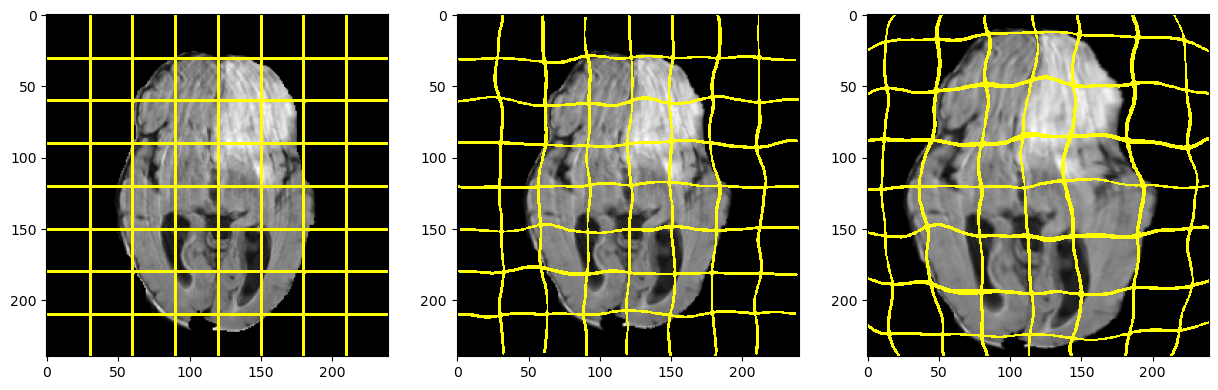

In [211]:
# NEW RESTORE 2
# (apply -dx not from the same point, but from (x+dx), back to x)
# Use original shifts

from scipy.ndimage import gaussian_filter
import elastic_transform

importlib.reload(elastic_transform)

transformed_2, dx, dy, unfiltered_dx, unfiltered_dy = elastic_transform.elastic_transform_NEW2(
    image, alpha=alpha, sigma=sigma, order=1)
grid_transformed_2, _, _ = elastic_transform.elastic_transform(grid, alpha=alpha, sigma=sigma,
                                                               dx=dx,
                                                               dy=dy, order=1)

# ---------------------------

unfiltered_dx_rounded = unfiltered_dx.round().astype(int)
unfiltered_dy_rounded = unfiltered_dy.round().astype(int)

shape = image.shape
xs = np.arange(shape[1]).astype(int)
ys = np.arange(shape[0]).astype(int)
x, y = np.meshgrid(xs, ys, indexing='xy')

x_shifted = x + unfiltered_dx_rounded
x_shifted = np.clip(x_shifted, 0, 239)

y_shifted = y + unfiltered_dy_rounded
y_shifted = np.clip(y_shifted, 0, 239)

# dx1, dy1 = np.meshgrid(xs, ys, indexing='xy')
unfiltered_dx1 = np.zeros(shape, dtype=float)
unfiltered_dy1 = np.zeros(shape, dtype=float)

unfiltered_dx1[y_shifted, x_shifted] = -unfiltered_dx  # x
#dx1 -= x

unfiltered_dy1[y_shifted, x_shifted] = -unfiltered_dy  # y


#dy1 -= y


def filter(d):
    return gaussian_filter(d, sigma, mode="constant", cval=0)


dx1 = filter(unfiltered_dx1)
dy1 = filter(unfiltered_dy1)

restored_2, _, _ = elastic_transform.elastic_transform(transformed_2, alpha=alpha, sigma=sigma,
                                                       dx=dx1, dy=dy1)
grid_restored_2, _, _ = elastic_transform.elastic_transform(grid_transformed_2, alpha=alpha,
                                                            sigma=sigma, dx=dx1,
                                                            dy=dy1)
#-------------------

columns = 3
rows = 1
fig = plt.figure(figsize=(15, 10))

# source
fig.add_subplot(rows, columns, 1)
plt.imshow(image.T, cmap='gray')
plt.imshow(grid.T, cmap=visualisation.grid_cmap)

# transformed
fig.add_subplot(rows, columns, 2)
plt.imshow(transformed_2.T, cmap='gray')
plt.imshow(grid_transformed_2.T, cmap=visualisation.grid_cmap)

# restored
fig.add_subplot(rows, columns, 3)
plt.imshow(restored_2.T, cmap='gray')
plt.imshow(grid_restored_2.T, cmap=visualisation.grid_cmap)



In [162]:
original = mri[0, :, :, 61]

print("For image:")
print(rmse(original, original))
print(rmse(original, transformed))
print(rmse(original, restored))
print(rmse(original, restored2))
print(rmse(original, restored3))
print(rmse(original, restored4))
print(rmse(original, restored5))

print("For grid:")
print(rmse(grid, grid))
print(rmse(grid, grid_transformed))
print(rmse(grid, grid_restored))
print(rmse(grid, grid_restored2))
print(rmse(grid, grid_restored3))
print(rmse(grid, grid_restored4))
print(rmse(grid, grid_restored5))

For image:
0.0
55.949268666864846
17.984257439373394
16.14432602843932
16.106152963224147
16.012468864732213
15.998543921961522
For grid:
0.0
0.3159824218240332
0.11419338165344349
0.10101121602895606
0.10033437322837896
0.09949133822175871
0.09929740729149966


In [3]:
# Inference

import importlib

importlib.reload(dproc)
importlib.reload(inference)

# Data loading
mri, target_segmentation = brats.load_sample(sample)

# Inference
checkpoint_path = "/Users/sw/msc_ai_diss/output/_vast/2023_08_29__21_48_13/checkpoint_epoch1000.pth"
# checkpoint_path = "/root/output/2023_08_29__21_48_13/checkpoint_complete_epoch1000.pth"
inf = inference.Inference(checkpoint_path, device=device)

dataset = dproc.sample_to_dataset(mri, device=device)
pred_batch = inf.predict(dataset)
logging.info(f"Pred shape: {pred_batch.shape}")


2023-09-16 19:52:41,991 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_flair.nii.gz (took 0.1s)
2023-09-16 19:52:42,081 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_t1.nii.gz (took 0.1s)
2023-09-16 19:52:42,163 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_t1ce.nii.gz (took 0.1s)
2023-09-16 19:52:42,247 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_t2.nii.gz (took 0.1s)
2023-09-16 19:52:42,263 [INFO] MRI image shape: (4, 240, 240, 144)
2023-09-16 19:52:42,278 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_seg.nii.gz (took 0.0s)
2023-09-16 1

In [38]:
# Loss

dice_loss = DiceLoss(device=device)

target_segmentation_batch = dproc.segmentation_sample_to_dataset(target_segmentation, device=device)
logging.info(f"Target segmentation batch shape: {target_segmentation_batch.shape}")

loss = dice_loss(pred_batch, target_segmentation_batch)
loss = loss.item()
logging.info(f"Loss (untransformed prediction vs target): {loss}")


2023-09-12 21:35:42,855 [INFO] Target segmentation batch shape: torch.Size([1, 1, 240, 240, 144])
2023-09-12 21:35:42,952 [INFO] Dice loss: 0.1293 (Dice score: 0.8707, per channel: [0.9997 0.6743 0.9103 0.8982]), took: 0.1s
2023-09-12 21:35:42,954 [INFO] Loss (untransformed prediction vs target): 0.12934261560440063


modalities shape: torch.Size([4, 240, 240, 144])


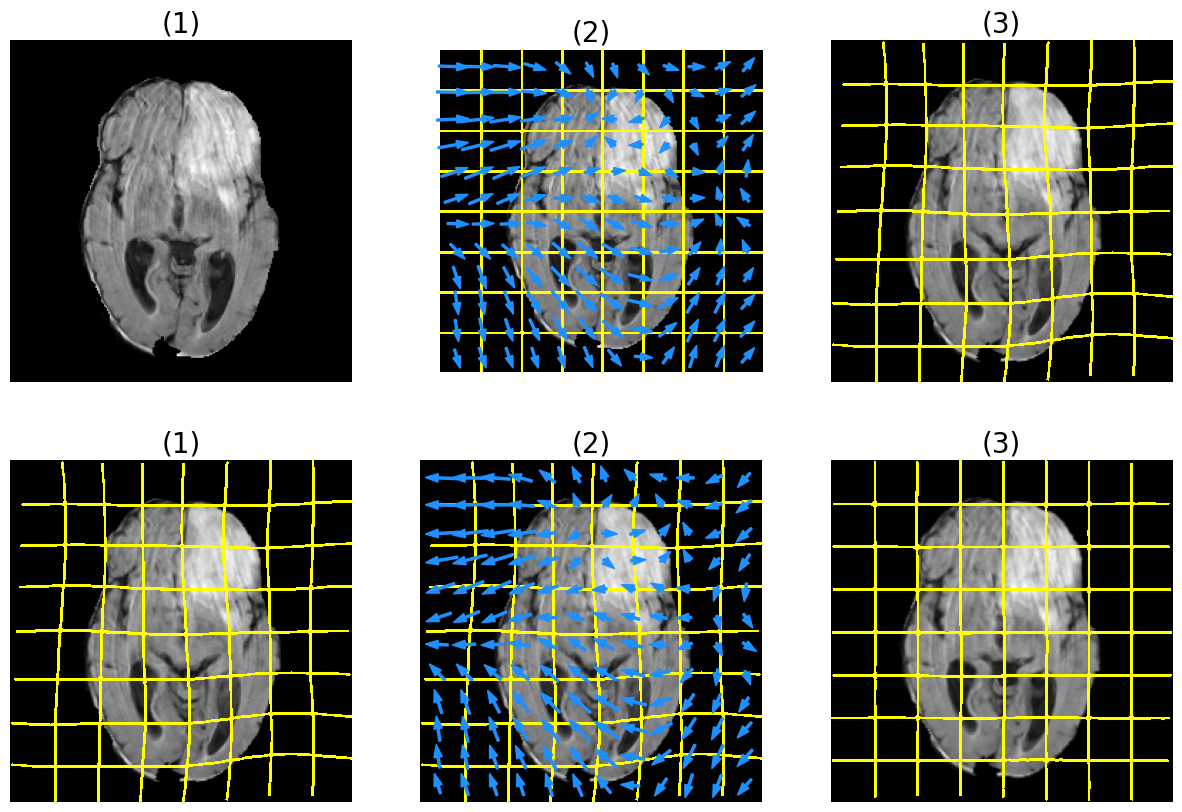

In [83]:
# Transformation and Visualisation 3D


import elastic_transform

importlib.reload(visualisation)
importlib.reload(elastic_transform)
importlib.reload(bd)
importlib.reload(dproc)

grid_3d = visualisation.create_grid_3d(mri[0].shape)

# alpha = 1000
# sigma = 20

# best for visualisation
alpha = 7800
sigma = 35

# alpha = 400
# sigma = 10

# alpha = 200
# sigma = 8

# alpha = 200
# sigma = 6

transform = elastic_transform.ElasticTransformation3D(alpha=alpha, sigma=sigma, order=1,
                                                      image_clipped=True)

transformed_4d = transform.transform_4d(mri)
transformed_3d = transformed_4d[0]  # taking the 1st channel
grid_transformed_3d = transform.transform_3d(grid_3d)

restored_3d = transform.restore_3d(transformed_3d)
grid_restored_3d = transform.restore_3d(grid_transformed_3d)

columns = 3
rows = 2
fig = plt.figure(figsize=(15, 10))

z_projection = 61  # 110 # 61  # 66

image_3d = mri[0]

# source
ax = fig.add_subplot(rows, columns, 1)
ax.set_title(f"(1)", fontsize=20)
ax.set_axis_off()
plt.imshow(image_3d[:, :, z_projection].T, cmap='gray')

# with grid and field
ax = fig.add_subplot(rows, columns, 2)
ax.set_title(f"(2)", fontsize=20)
ax.set_axis_off()
plt.imshow(image_3d[:, :, z_projection].T, cmap='gray')
plt.imshow(grid_3d[:, :, z_projection].T, cmap=visualisation.grid_cmap)
transform.draw_displacement_forces(z_projection)
# plt.imshow(grid_transformed_3d[:, :, z_projection].T, cmap=colors.ListedColormap(['none', 'blue']))

# transformed with grid
ax = fig.add_subplot(rows, columns, 3)
ax.set_title(f"(3)", fontsize=20)
ax.set_axis_off()
plt.imshow(transformed_3d[:, :, z_projection].T, cmap='gray')
plt.imshow(grid_transformed_3d[:, :, z_projection].T, cmap=visualisation.grid_cmap)

# transformed with grid
ax = fig.add_subplot(rows, columns, 4)
ax.set_title(f"(1)", fontsize=20)
ax.set_axis_off()
plt.imshow(transformed_3d[:, :, z_projection].T, cmap='gray')
plt.imshow(grid_transformed_3d[:, :, z_projection].T, cmap=visualisation.grid_cmap)

# transformed with grid - with forces
ax = fig.add_subplot(rows, columns, 5)
ax.set_title(f"(2)", fontsize=20)
ax.set_axis_off()
plt.imshow(transformed_3d[:, :, z_projection].T, cmap='gray')
plt.imshow(grid_transformed_3d[:, :, z_projection].T, cmap=visualisation.grid_cmap)
transform.draw_displacement_forces(z_projection, reverse=True)

# restored with grid
ax = fig.add_subplot(rows, columns, 6)
ax.set_title(f"(3)", fontsize=20)
ax.set_axis_off()
plt.imshow(restored_3d[:, :, z_projection].T, cmap='gray')
plt.imshow(grid_restored_3d[:, :, z_projection].T, cmap=visualisation.grid_cmap)

# # restored - no grid
# ax = fig.add_subplot(rows, columns, 5)
# ax.set_title(f"(5)", fontsize=20)
# ax.set_axis_off()
# plt.imshow(restored_3d[:, :, z_projection].T, cmap='gray')

# # restored with grid (order 2)
# fig.add_subplot(rows, columns, 5)
# plt.imshow(restored_3d_2[:, :, z_projection].T, cmap='gray')
# plt.imshow(grid_restored_3d_2[:, :, z_projection].T, cmap=visualisation.grid_cmap)

plt.show()


In [87]:
# Inference against transformed image

importlib.reload(dproc)
importlib.reload(inference)
importlib.reload(pipeline)
import elastic_transform

importlib.reload(elastic_transform)

transformation_count = 5

logger.info("start")

sample = 1552  # 547
mri, target_segmentation = brats.load_sample(sample)
#
# alpha = 10000
# sigma = 40

# alpha = 7000
# sigma = 40

alpha = 7800
sigma = 35

pipelines = []
for i in range(transformation_count):
    print(f"Processing #{i + 1} of {transformation_count}")
    tp = pipeline.TransformationPipeline(mri, target_segmentation[0], inf, device, alpha=alpha,
                                         sigma=sigma, restore_order=3)
    pipelines.append(tp)

logger.info("done")


2023-09-18 21:15:53,792 [INFO] start
2023-09-18 21:15:53,885 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_flair.nii.gz (took 0.1s)
2023-09-18 21:15:53,973 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_t1.nii.gz (took 0.1s)
2023-09-18 21:15:54,055 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_t1ce.nii.gz (took 0.1s)
2023-09-18 21:15:54,138 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_t2.nii.gz (took 0.1s)
2023-09-18 21:15:54,155 [INFO] MRI image shape: (4, 240, 240, 144)
2023-09-18 21:15:54,182 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_0155

2023-09-18 23:27:56,281 [INFO] Dice loss: 0.0868 (Dice score: 0.9132, per channel: [0.9851 0.9211 0.8445 0.9020]), took: 0.1s
2023-09-18 23:27:56,284 [INFO] Restored loss: 0.08684957027435303
2023-09-18 23:27:56,417 [INFO] Dice loss: 0.0949 (Dice score: 0.9051, per channel: [0.9782 0.9135 0.8384 0.8904]), took: 0.1s
2023-09-18 23:27:56,419 [INFO] Restored loss: 0.0948745608329773
2023-09-18 23:27:56,541 [INFO] Dice loss: 0.0851 (Dice score: 0.9149, per channel: [0.9860 0.9318 0.8492 0.8924]), took: 0.1s
2023-09-18 23:27:56,542 [INFO] Restored loss: 0.08513802289962769
2023-09-18 23:27:56,669 [INFO] Dice loss: 0.0798 (Dice score: 0.9202, per channel: [0.9851 0.9284 0.8697 0.8975]), took: 0.1s
2023-09-18 23:27:56,671 [INFO] Restored loss: 0.07981216907501221
2023-09-18 23:27:56,789 [INFO] Dice loss: 0.0893 (Dice score: 0.9107, per channel: [0.9781 0.9225 0.8437 0.8987]), took: 0.1s
2023-09-18 23:27:56,791 [INFO] Restored loss: 0.0892791748046875
2023-09-18 23:27:57,276 [INFO] prediction_

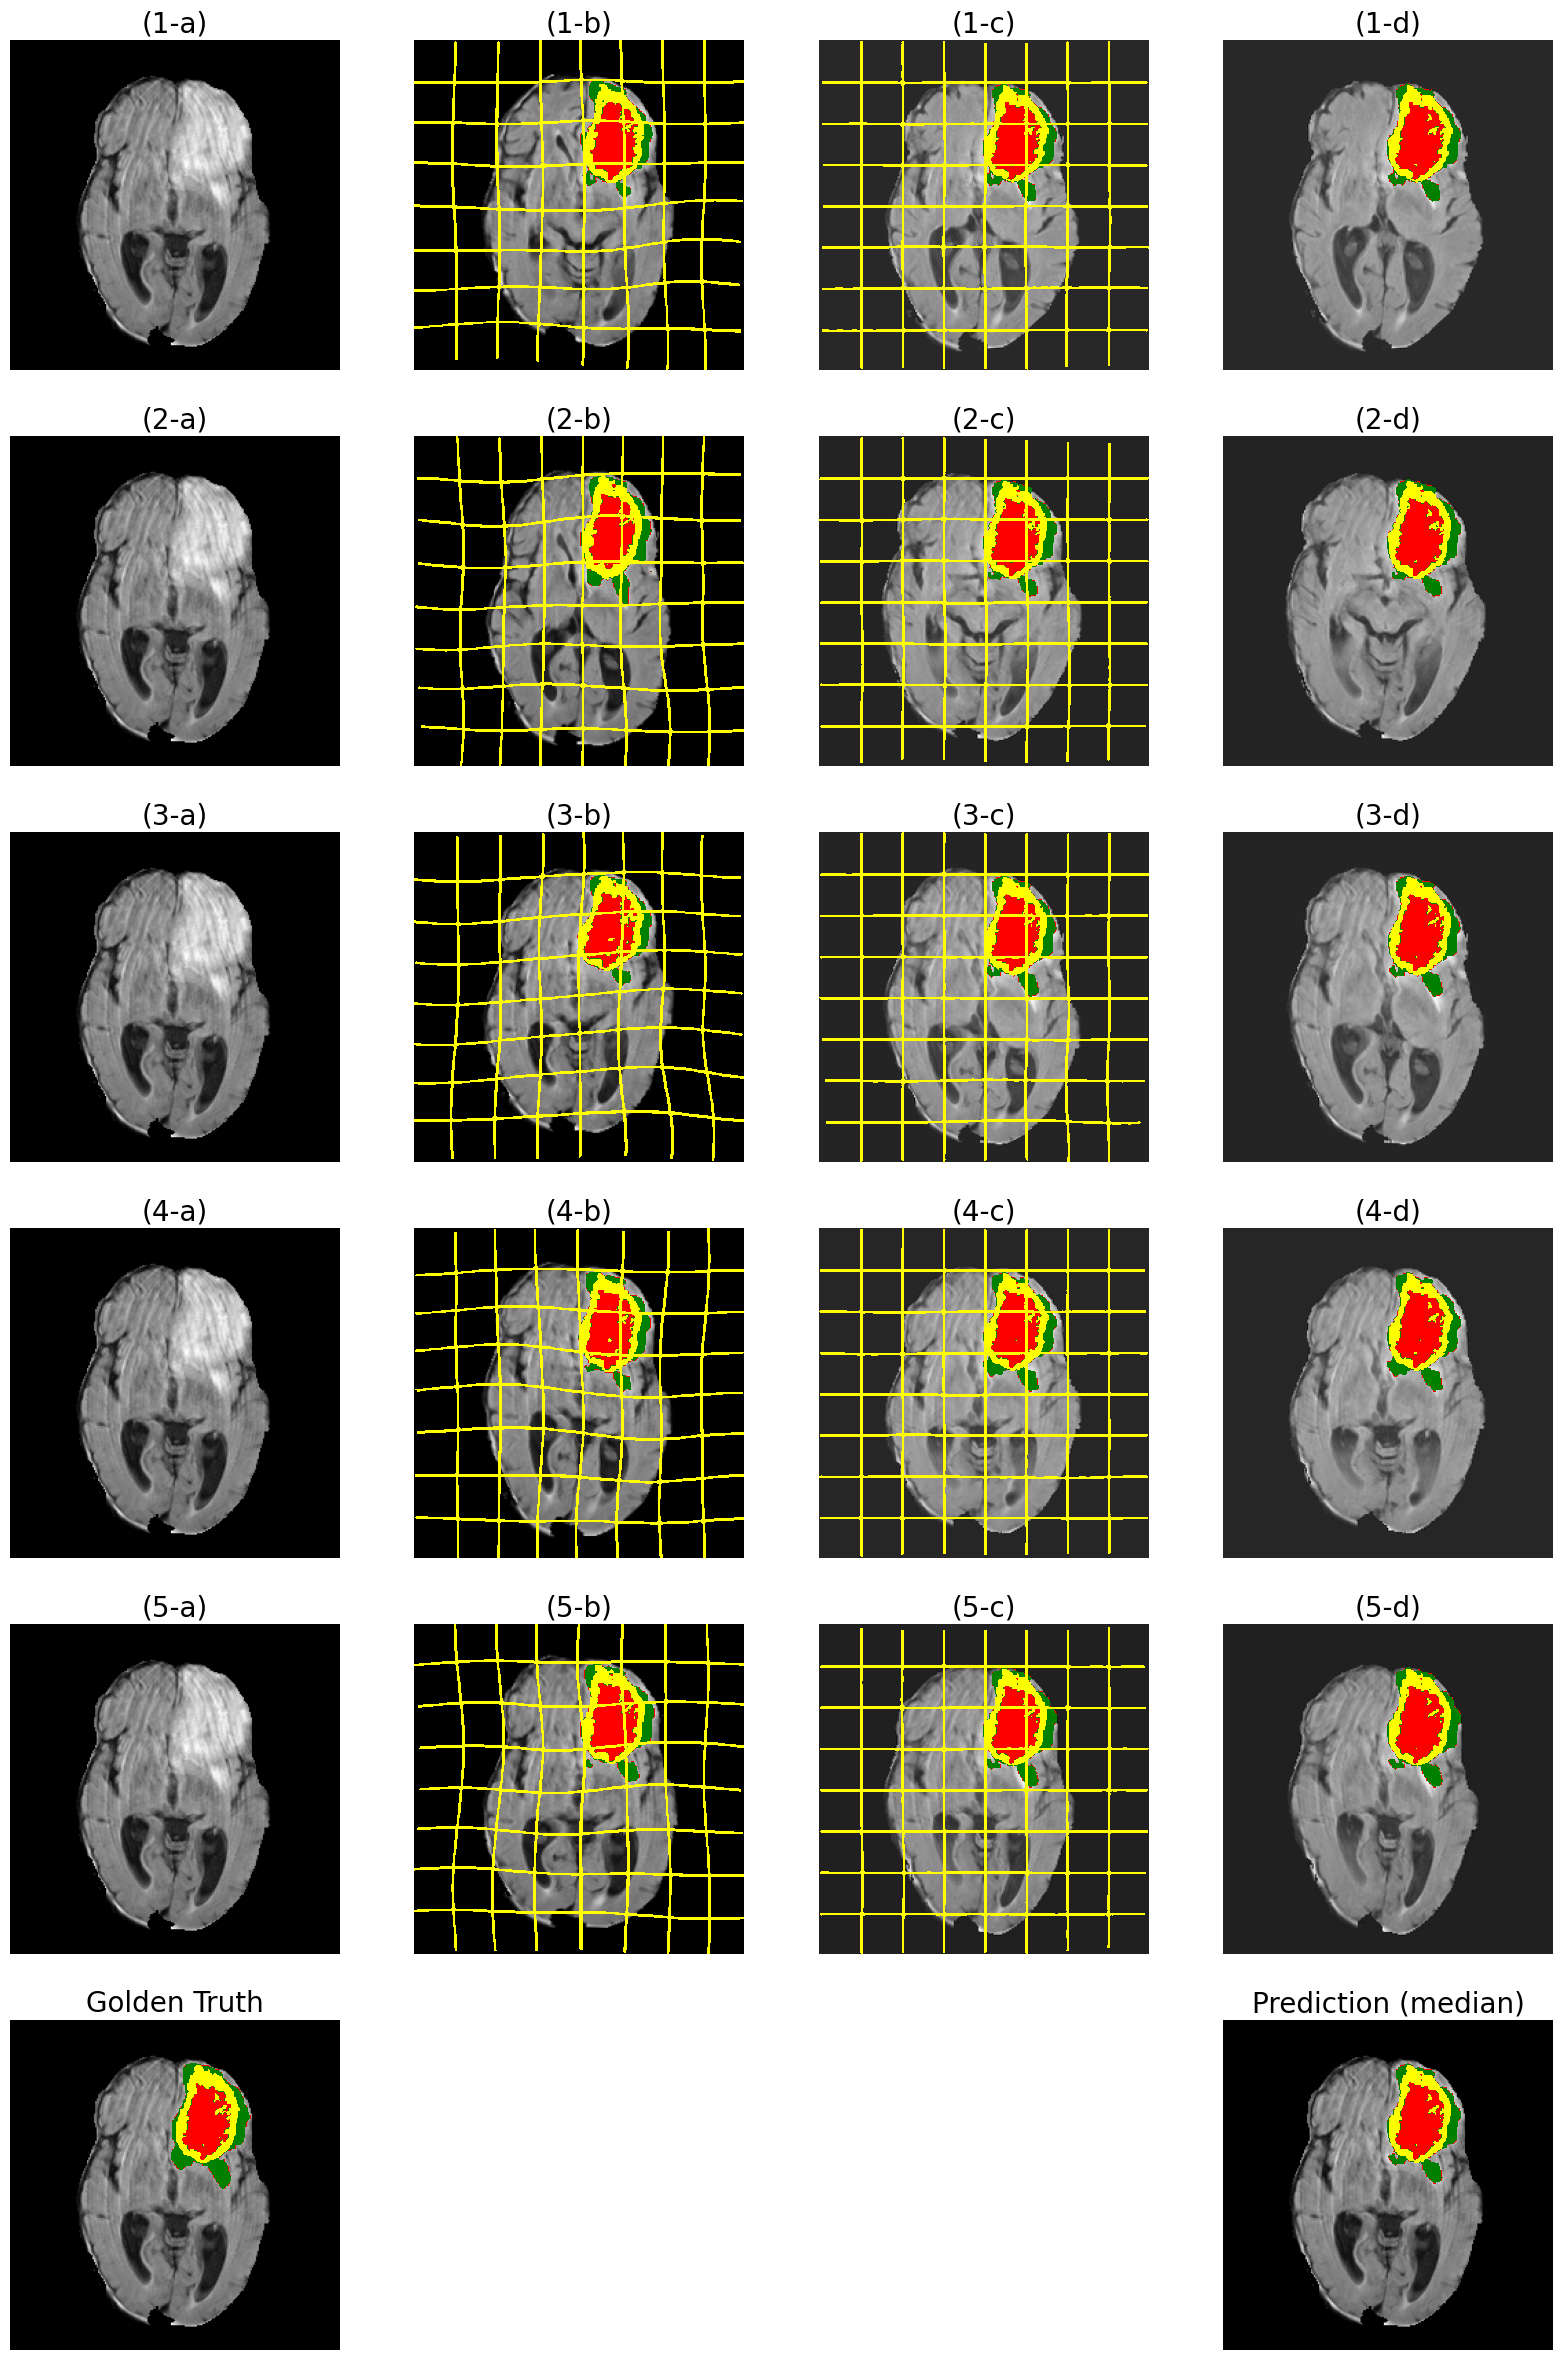

In [93]:
# Visualisation 3D

import elastic_transform

importlib.reload(visualisation)
importlib.reload(elastic_transform)
importlib.reload(bd)
importlib.reload(dproc)
importlib.reload(pipeline)
import loss

importlib.reload(loss)

columns = 4
# rows = transformation_count * 2
rows = transformation_count + 1
fig = plt.figure(figsize=(5 * columns, 5 * rows))

z_projection = 61  #  110 for 547 # 61 for 1552
modality = 0

dice_loss = loss.DiceLoss(device=device)

chart_num = 1

row = 1
for p in pipelines:
    # source
    ax = fig.add_subplot(rows, columns, chart_num)
    ax.set_title(f"({row}-a)", fontsize=20)
    ax.set_axis_off()
    chart_num += 1
    plt.imshow(p.mri_4d[modality, :, :, z_projection].T, cmap='gray')
    #plt.imshow(p.target_segmentation_3d[:, :, z_projection].T, cmap=visualisation.segmentation_cmap)

    # # source - with grid
    # ax = fig.add_subplot(rows, columns, chart_num)
    # ax.set_title(f"(2)", fontsize=20)
    # ax.set_axis_off()
    # chart_num += 1
    # plt.imshow(p.mri_4d[modality, :, :, z_projection].T, cmap='gray')
    # plt.imshow(p.grid_3d[:, :, z_projection].T, cmap=visualisation.grid_cmap)
    #
    # # source - with grid and forces
    # ax = fig.add_subplot(rows, columns, chart_num)
    # ax.set_title(f"(3)", fontsize=20)
    # ax.set_axis_off()
    # chart_num += 1
    # plt.imshow(p.mri_4d[modality, :, :, z_projection].T, cmap='gray')
    # plt.imshow(p.grid_3d[:, :, z_projection].T, cmap=visualisation.grid_cmap)
    # p.transform.draw_displacement_forces(z_projection)

    # source - transformed with grid
    # ax = fig.add_subplot(rows, columns, chart_num)
    # ax.set_title(f"({row}-b)", fontsize=20)
    # ax.set_axis_off()
    # chart_num += 1
    # plt.imshow(p.mri_transformed_4d[modality, :, :, z_projection].T, cmap='gray')
    # plt.imshow(p.grid_transformed_3d[:, :, z_projection].T, cmap=visualisation.grid_cmap)

    # pred - transformed with grid
    ax = fig.add_subplot(rows, columns, chart_num)
    ax.set_title(f"({row}-b)", fontsize=20)
    ax.set_axis_off()
    chart_num += 1
    plt.imshow(p.mri_transformed_4d[modality, :, :, z_projection].T, cmap='gray')
    plt.imshow(p.pred_segmentation_transformed_3d[:, :, z_projection].T,
               cmap=visualisation.segmentation_cmap)
    plt.imshow(p.grid_transformed_3d[:, :, z_projection].T, cmap=visualisation.grid_cmap)

    # pred - restored with grid
    ax = fig.add_subplot(rows, columns, chart_num)
    ax.set_title(f"({row}-c)", fontsize=20)
    ax.set_axis_off()
    chart_num += 1
    plt.imshow(p.mri_restored_4d[modality, :, :, z_projection].T, cmap='gray')
    plt.imshow(p.pred_segmentation_restored_3d[:, :, z_projection].T,
               cmap=visualisation.segmentation_cmap)
    plt.imshow(p.grid_restored_3d[:, :, z_projection].T, cmap=visualisation.grid_cmap)

    # pred - restored
    ax = fig.add_subplot(rows, columns, chart_num)
    ax.set_title(f"({row}-d)", fontsize=20)
    ax.set_axis_off()
    chart_num += 1
    plt.imshow(p.mri_restored_4d[modality, :, :, z_projection].T, cmap='gray')
    plt.imshow(p.pred_segmentation_restored_3d[:, :, z_projection].T,
               cmap=visualisation.segmentation_cmap)

    # # pred - transformed with forces
    # ax = fig.add_subplot(rows, columns, chart_num)
    # ax.set_title(f"(6)", fontsize=20)
    # ax.set_axis_off()
    # chart_num += 1
    # plt.imshow(p.mri_transformed_4d[modality, :, :, z_projection].T, cmap='gray')
    # plt.imshow(p.pred_segmentation_transformed_3d[:, :, z_projection].T,
    #            cmap=visualisation.segmentation_cmap)
    # plt.imshow(p.grid_transformed_3d[:, :, z_projection].T, cmap=visualisation.grid_cmap)
    # p.transform.draw_displacement_forces(z_projection, reverse=True)
    #

    logging.info(f"Restored loss: {p.restored_loss()}")
    row += 1

p = pipelines[0]
shape = p.mri_4d[modality].T.shape

# LAST ROW

# Original with truth segmentation
ax = fig.add_subplot(rows, columns, chart_num)
ax.set_title(f"Golden Truth", fontsize=20)
ax.set_axis_off()
chart_num += 1
plt.imshow(p.mri_4d[modality, :, :, z_projection].T, cmap='gray')
plt.imshow(p.target_segmentation_3d[:, :, z_projection].T,
           cmap=visualisation.segmentation_cmap)

# placeholders
for _ in range(2):
    ax = fig.add_subplot(rows, columns, chart_num)
    ax.set_axis_off()
    chart_num += 1
    plt.imshow(np.zeros(shape[1:]), cmap=visualisation.placeholder_cmap)

# Calculate predicted segmentation
all_pred_restored_4d = torch.stack([p.pred_restored_4d for p in pipelines])
avg_pred_restored_4d, _ = torch.median(all_pred_restored_4d, dim=0)
avg_segmentation_restored_3d = dproc.segmentation_3d_from_prediction_4d(avg_pred_restored_4d)

# average restored
ax = fig.add_subplot(rows, columns, chart_num)
ax.set_title(f"Prediction (median)", fontsize=20)
ax.set_axis_off()
chart_num += 1
plt.imshow(p.mri_4d[modality, :, :, z_projection].T, cmap='gray')
plt.imshow(avg_segmentation_restored_3d[:, :, z_projection].T,
           cmap=visualisation.segmentation_cmap)

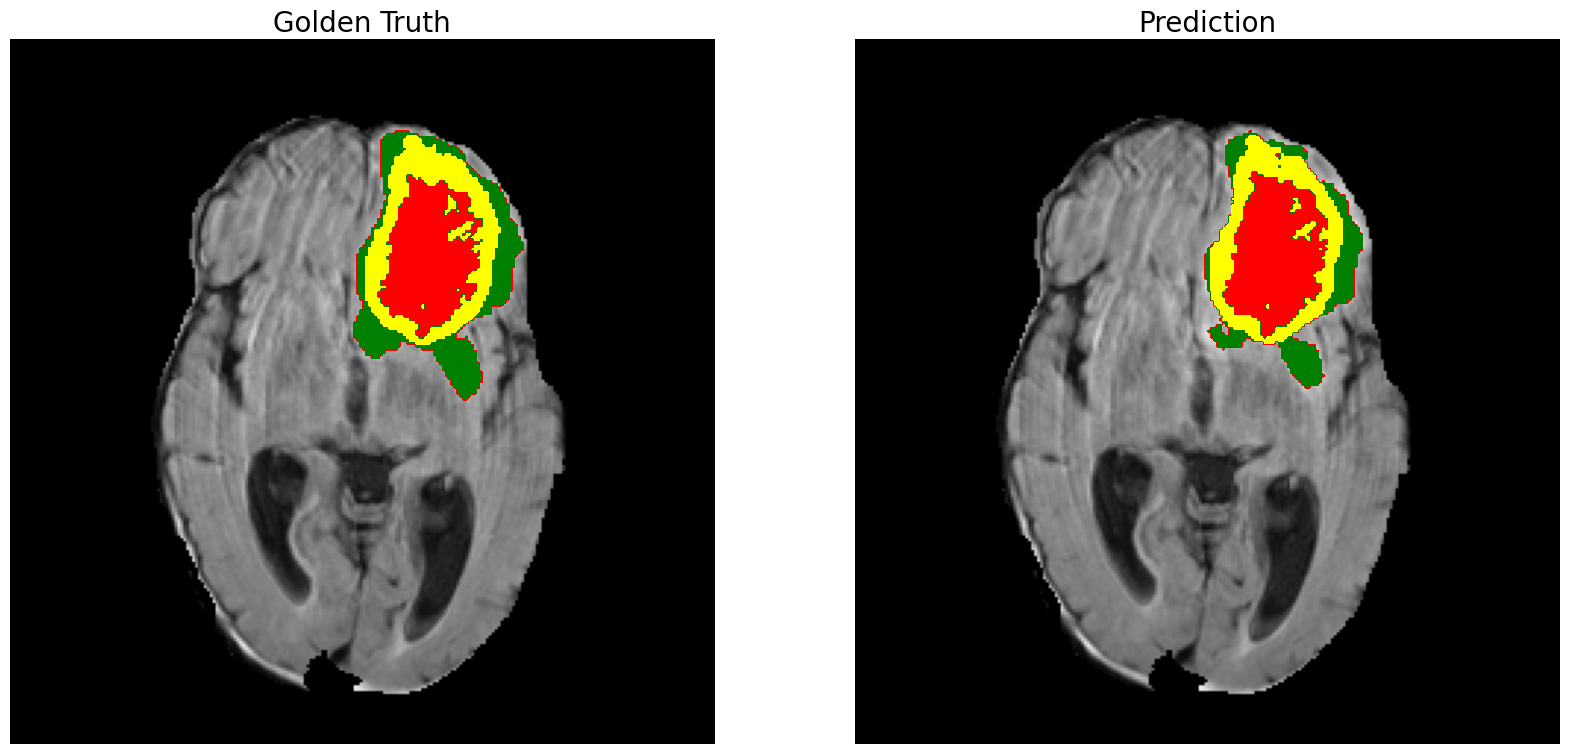

In [95]:
# Just truth VS prediction

columns = 2
# rows = transformation_count * 2
rows = 1
fig = plt.figure(figsize=(10 * columns, 10 * rows))
chart_num = 1
# Original with truth segmentation
ax = fig.add_subplot(rows, columns, chart_num)
ax.set_title(f"Golden Truth", fontsize=20)
ax.set_axis_off()
chart_num += 1
plt.imshow(p.mri_4d[modality, :, :, z_projection].T, cmap='gray')
plt.imshow(p.target_segmentation_3d[:, :, z_projection].T,
           cmap=visualisation.segmentation_cmap)

# average restored
ax = fig.add_subplot(rows, columns, chart_num)
ax.set_title(f"Prediction", fontsize=20)
ax.set_axis_off()
chart_num += 1
plt.imshow(p.mri_4d[modality, :, :, z_projection].T, cmap='gray')
plt.imshow(avg_segmentation_restored_3d[:, :, z_projection].T,
           cmap=visualisation.segmentation_cmap)

In [98]:
# Loss comparison

import scipy
import loss

importlib.reload(loss)
dice_loss = loss.DiceLoss(device=device)

# original_loss = dice_loss.calculate_dice_loss(pred_batch[0], segmentation[0])
# print(f"original loss: {original_loss}")

# all_pred_restored_4d = torch.stack([p.pred_restored_4d for p in pipelines])
# avg_pred_restored_4d, _ = torch.median(all_pred_restored_4d, dim=0)

print(all_pred_restored_4d.shape)

#avg_pred_restored_4d, _ = torch.median(all_pred_restored_4d, dim=0)
# print(torch.isnan(all_pred_restored_4d).count_nonzero())
# avg_pred_restored_4d = scipy.stats.mstats.gmean(all_pred_restored_4d, axis=0, nan_policy="raise")
# avg_pred_restored_4d = np.sqrt(np.square(all_pred_restored_4d).mean(axis=0))

print(avg_pred_restored_4d.shape)
# print(np.unique(avg_pred_restored_4d))

avg_segmentation_restored_3d = dproc.segmentation_3d_from_prediction_4d(avg_pred_restored_4d)
print(avg_segmentation_restored_3d.shape)

rl = dice_loss.calculate_dice_loss(avg_pred_restored_4d, segmentation[0]).item()
print(f"avg restored loss: {rl}")



torch.Size([5, 4, 240, 240, 144])
torch.Size([4, 240, 240, 144])
2023-09-19 07:05:26,342 [INFO] prediction_4d shape: torch.Size([4, 240, 240, 144])
2023-09-19 07:05:26,343 [INFO] prediction_4d shape: torch.Size([4, 240, 240, 144])
2023-09-19 07:05:27,554 [INFO] Prediction shape: torch.Size([240, 240, 144])
torch.Size([240, 240, 144])
2023-09-19 07:05:27,717 [INFO] Dice loss: 0.0824 (Dice score: 0.9176, per channel: [0.9879 0.9287 0.8495 0.9043]), took: 0.2s
avg restored loss: 0.08240735530853271


In [72]:
# Hausdorff

from skimage import metrics

orig_pred_segmentation_3d = dproc.segmentation_3d_from_prediction_4d(pred_batch[0])


2023-09-12 22:33:19,989 [INFO] prediction_4d shape: torch.Size([4, 240, 240, 144])
2023-09-12 22:33:19,990 [INFO] prediction_4d shape: torch.Size([4, 240, 240, 144])
2023-09-12 22:33:21,323 [INFO] Prediction shape: torch.Size([240, 240, 144])


In [17]:
from skimage import metrics

# orig_pred_segmentation_3d_mask_class1 = orig_pred_segmentation_3d == 1

# print(orig_pred_segmentation_3d_mask_class1.shape)
# print(segmentation[0].shape)

for klass in range(1, 4):
    d = metrics.hausdorff_distance(segmentation[0] == klass,
                                   (orig_pred_segmentation_3d == klass).numpy())
    d2 = metrics.hausdorff_distance(segmentation[0] == klass,
                                    (avg_segmentation_restored_3d == klass).numpy())
    print(f"Class {klass}: d={d}, d2={d2}")


NameError: name 'orig_pred_segmentation_3d' is not defined

In [74]:
# Hausdorff 95%

import seg_metrics.seg_metrics as sg

csv_file = 'metrics.csv.tmp'
metrics_to_calculate = ['dice', 'hd', 'hd95', 'precision', 'recall']
classes = [1, 2, 3]


def calculate_metrics(pred):
    metrics = sg.write_metrics(labels=classes,  # exclude background
                               gdth_img=segmentation[0],
                               pred_img=pred,
                               csv_file=csv_file,
                               metrics=metrics_to_calculate)
    for m in metrics_to_calculate:
        print(f"{m}:\t ", end="")
        for c in classes:
            print(f"\t{metrics[0][m][int(c) - 1]:.4f}", end="")
        print()


calculate_metrics(orig_pred_segmentation_3d.numpy())
calculate_metrics(avg_segmentation_restored_3d.numpy())

print(rmse(segmentation[0], orig_pred_segmentation_3d.numpy()))
print(rmse(segmentation[0], avg_segmentation_restored_3d.numpy()))


2023-09-12 22:52:20,521 [INFO] start to calculate metrics (volume or distance) and write them to csv


0it [00:00, ?it/s]--- Logging error ---
Traceback (most recent call last):
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3.11/logging/__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3.11/logging/__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3.11/logging/__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3.11/logging/__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/sw/mambaforge/envs/mamba-dis-pyt

dice:	 	0.6741	0.9105	0.8986
hd:	 	6.4031	56.9561	3.6056
hd95:	 	2.4495	1.4142	1.4142
precision:	 	0.9550	0.8839	0.8320
recall:	 	0.5209	0.9388	0.9768
2023-09-12 22:52:21,993 [INFO] start to calculate metrics (volume or distance) and write them to csv



--- Logging error ---
Traceback (most recent call last):
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3.11/logging/__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3.11/logging/__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3.11/logging/__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3.11/logging/__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3

dice:	 	0.6693	0.9081	0.8912
hd:	 	6.4031	56.5509	3.6056
hd95:	 	2.4495	1.4142	1.4142
precision:	 	0.9609	0.8819	0.8164
recall:	 	0.5135	0.9360	0.9812
0.051358380583628606
0.05176639680297406



--- Logging error ---
Traceback (most recent call last):
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3.11/logging/__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3.11/logging/__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3.11/logging/__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3.11/logging/__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/sw/mambaforge/envs/mamba-dis-pytorch2/lib/python3

In [246]:
# Averaging segmentations (instead of predictions)

def pred_seg_to_pred_4d(pred_seg):
    assert len(pred_seg.shape) == 3
    num_classes = 4
    print("segmentation.shape: ", pred_seg.shape)
    seg = torch.as_tensor(pred_seg, dtype=torch.int)
    print("segmentation.shape: ", seg.shape)
    seg = seg[np.newaxis, ...]
    print("segmentation.shape: ", seg.shape)
    eye = torch.eye(num_classes, device=device)
    print("eye.shape: ", eye.shape)
    result_onehot1 = eye[seg]  # [B, H, W, D, C]
    print("result_onehot1.shape: ", result_onehot1.shape)
    result_onehot1 = result_onehot1.permute(0, 4, 1, 2, 3).float()  # [B, C, H, W, D]
    print("result_onehot1.shape: ", result_onehot1.shape)
    result = result_onehot1[0]

    print("result.shape: ", result_onehot1.shape)
    return result


ttt = dice_loss.calculate_dice_loss(pred_seg_to_pred_4d(avg_segmentation_restored_3d),
                                    segmentation[0]).item()
print(f"loss of original prediction: {ttt}")

orig_pred_segmentation_3d = dproc.segmentation_3d_from_prediction_4d(pred_batch[0])

all_pr = [p.pred_restored_4d for p in pipelines]
all_seg = np.array([dproc.segmentation_3d_from_prediction_4d(pr) for pr in all_pr])
all_pred_segmentations_restored = torch.as_tensor(all_seg, dtype=torch.int32)
print("all_pred_segmentations_restored.shape: ", all_pred_segmentations_restored.shape)
avg_pred_segmentation_restored, _ = torch.mode(all_pred_segmentations_restored, dim=0)
print("avg_pred_segmentation_restored.shape: ", avg_pred_segmentation_restored.shape)

rl_2 = dice_loss.calculate_dice_loss(pred_seg_to_pred_4d(avg_pred_segmentation_restored),
                                     segmentation[0]).item()
print(f"avg restored loss 2: {rl_2}")



segmentation.shape:  torch.Size([240, 240, 144])
segmentation.shape:  torch.Size([240, 240, 144])
segmentation.shape:  torch.Size([1, 240, 240, 144])
eye.shape:  torch.Size([4, 4])
result_onehot1.shape:  torch.Size([1, 240, 240, 144, 4])
result_onehot1.shape:  torch.Size([1, 4, 240, 240, 144])
result.shape:  torch.Size([1, 4, 240, 240, 144])
2023-09-11 19:46:12,791 [INFO] Dice loss: 0.0699 (Dice score: 0.9301, per channel: [0.9982 0.9413 0.8574 0.9234]), took: 0.1s
loss of original prediction: 0.06992000341415405
2023-09-11 19:46:12,794 [INFO] prediction_4d shape: torch.Size([4, 240, 240, 144])
2023-09-11 19:46:12,794 [INFO] prediction_4d shape: torch.Size([4, 240, 240, 144])
2023-09-11 19:46:14,114 [INFO] Prediction shape: torch.Size([240, 240, 144])
2023-09-11 19:46:14,115 [INFO] prediction_4d shape: torch.Size([4, 240, 240, 144])
2023-09-11 19:46:14,115 [INFO] prediction_4d shape: torch.Size([4, 240, 240, 144])
2023-09-11 19:46:15,395 [INFO] Prediction shape: torch.Size([240, 240, 1

2023-09-11 19:47:02,121 [INFO] prediction_4d shape: torch.Size([4, 240, 240, 144])
2023-09-11 19:47:02,122 [INFO] prediction_4d shape: torch.Size([4, 240, 240, 144])
2023-09-11 19:47:03,434 [INFO] Prediction shape: torch.Size([240, 240, 144])


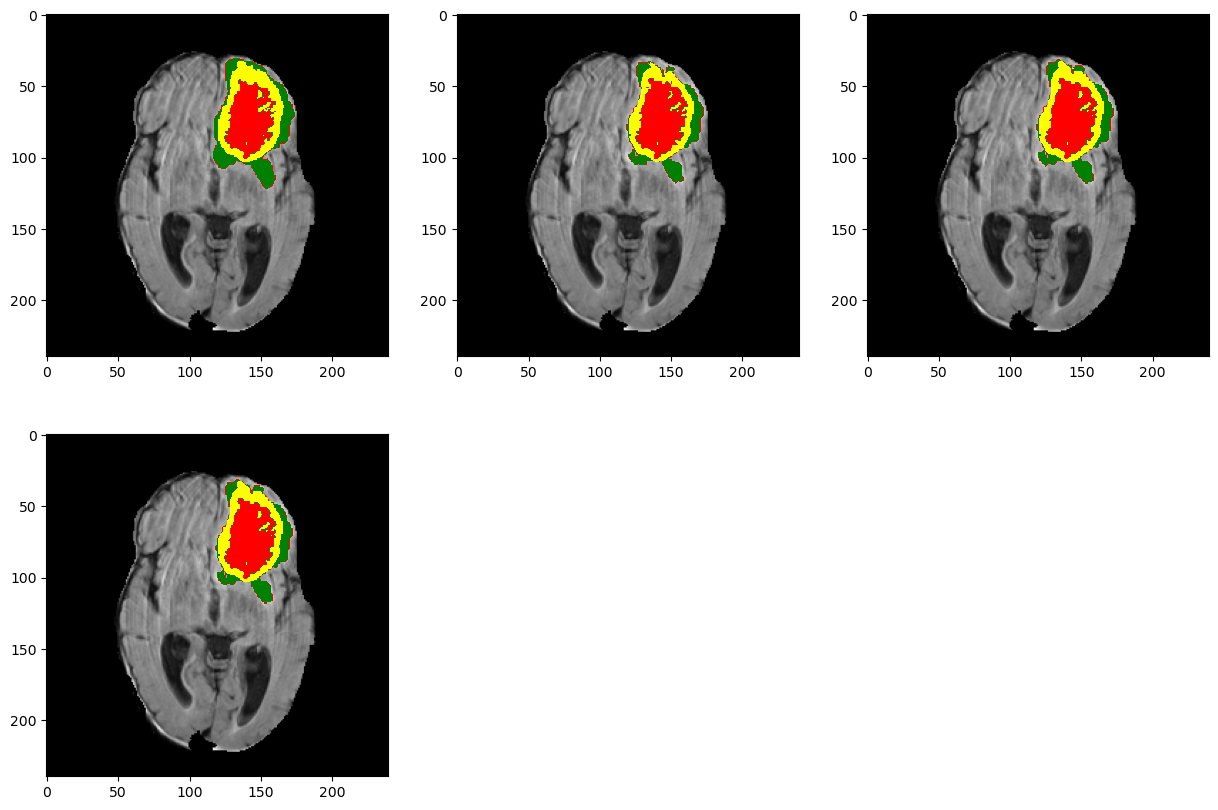

In [247]:
columns = 3
rows = 2
fig = plt.figure(figsize=(15, 5 * rows))

chart_num = 1

# source
fig.add_subplot(rows, columns, chart_num)
chart_num += 1
plt.imshow(mri[modality, :, :, z_projection].T, cmap='gray')
plt.imshow(segmentation[0, :, :, z_projection].T, cmap=visualisation.segmentation_cmap)

# original prediction
fig.add_subplot(rows, columns, chart_num)
chart_num += 1
plt.imshow(mri[modality, :, :, z_projection].T, cmap='gray')
pred_segmentation_3d = dproc.segmentation_3d_from_prediction_4d(pred_batch[0])
plt.imshow(pred_segmentation_3d[:, :, z_projection].T, cmap=visualisation.segmentation_cmap)

# avg restored
fig.add_subplot(rows, columns, chart_num)
chart_num += 1
plt.imshow(mri[modality, :, :, z_projection].T, cmap='gray')
plt.imshow(avg_segmentation_restored_3d[:, :, z_projection].T,
           cmap=visualisation.segmentation_cmap)  # avg restored

# avg restored - 2
fig.add_subplot(rows, columns, chart_num)
chart_num += 1
plt.imshow(mri[modality, :, :, z_projection].T, cmap='gray')
plt.imshow(avg_pred_segmentation_restored[:, :, z_projection].T,
           cmap=visualisation.segmentation_cmap)

In [47]:
print(rmse(pred_segmentation_3d.numpy(), segmentation[0]))
print(rmse(avg_segmentation_restored_3d.numpy(), segmentation[0]))
print(rmse(avg_pred_segmentation_restored.numpy(), segmentation[0]))

NameError: name 'pred_segmentation_3d' is not defined

In [190]:
# HIGHER DEF

import elastic_transform
import importlib

importlib.reload(elastic_transform)

alpha = 700
sigma = 10

transformed, dx, dy, dz = elastic_transform.elastic_transform_3d_HIGHER_DEF(grid_3d, alpha=alpha,
                                                                            sigma=sigma)  #  mri[0]

restored, _, _, _ = elastic_transform.elastic_transform_3d_HIGHER_DEF(transformed.numpy(),
                                                                      alpha=alpha, sigma=sigma,
                                                                      dx=-dx, dy=-dy,
                                                                      dz=-dz)  #  mri[0]

KeyboardInterrupt: 

In [ ]:
import visualisation

importlib.reload(visualisation)

columns = 3
rows = 1
fig = plt.figure(figsize=(15, 5 * rows))

chart_num = 1

# source
fig.add_subplot(rows, columns, chart_num)
chart_num += 1
plt.imshow(transformed[:, :, z_projection].T, cmap=visualisation.grid_with_bg_cmap)

# original prediction
fig.add_subplot(rows, columns, chart_num)
chart_num += 1
plt.imshow(restored[:, :, z_projection].T, cmap=visualisation.grid_with_bg_cmap)
